In [4]:
import mlrose_hiive as mlr
import numpy as np
import sys
sys.path.append('./pyperch') 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import SARunner, GARunner, RHCRunner, NNGSRunner

In [5]:
from pyperch.neural.backprop_nn import BackpropModule

In [4]:
print(BackpropModule)

<class 'pyperch.neural.backprop_nn.BackpropModule'>


In [21]:
# Problem 1 -- Warehouse Layout Optimization Problem
# Define the layout dimensions and other constants
layout_width = 10
layout_height = 10
num_cells = layout_width * layout_height
num_racks = 50  # Number of storage racks
num_aisles = num_cells - num_racks  # Number of aisles

# Define the entry/exit point(s)
entry_exit_points = [(0, 0)]

# Define the fitness function
def travel_distance(state):
    layout = np.array(state).reshape(layout_height, layout_width)
    total_distance = 0

    for (i, row) in enumerate(layout):
        for (j, cell) in enumerate(row):
            if cell == 1:  # If the cell is a storage rack
                min_distance = float('inf')
                for (entry_i, entry_j) in entry_exit_points:
                    distance = abs(entry_i - i) + abs(entry_j - j)
                    if distance < min_distance:
                        min_distance = distance
                total_distance += min_distance
    
    # Check accessibility
    # Here you should add your logic to check if all racks are accessible
    # If not accessible, add a penalty to total_distance

    return total_distance

# Create a fitness object
fitness = mlr.CustomFitness(travel_distance)



# Define the optimization problem object
problem = mlr.DiscreteOpt(length=num_cells, fitness_fn=fitness, maximize=False, max_val=2)

# Define the initial state (randomly placing racks and aisles)
initial_state = np.random.choice([0, 1], size=num_cells, p=[num_aisles/num_cells, num_racks/num_cells])


In [22]:
sa = SARunner(problem=problem,
              experiment_name='warehouse_sa',
              output_directory="./warehouse", # note: specify an output directory to have results saved to disk
              seed=42,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              temperature_list=[0.1, 0.5, 0.75, 1.0, 2.0, 5.0],
              decay_list=[mlr.GeomDecay],
              init_state=initial_state)

wh_sa_run_stats, wh_sa_run_curves = sa.run()

In [27]:
wh_sa_run_stats.head


<bound method NDFrame.head of     Iteration  Fitness  FEvals      Time  \
0           0    469.0       1  0.000197   
1           1    463.0       3  0.006329   
2           2    452.0       5  0.012167   
3           4    439.0       9  0.016247   
4           8    439.0      13  0.022636   
..        ...      ...     ...       ...   
67         64    306.0     103  0.335816   
68        128    185.0     190  0.389481   
69        256     50.0     341  0.450069   
70        512      9.0     606  0.532525   
71       1024      0.0    1123  0.697109   

                                                State schedule_type  \
0   [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...     geometric   
1   [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...     geometric   
2   [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...     geometric   
3   [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, ...     geometric   
4   [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, ...     geometric   
..             

In [26]:
best_state = wh_sa_run_stats.loc[wh_sa_run_stats['Fitness'].idxmax()]['State']
best_fitness = wh_sa_run_stats['Fitness'].min()

best_state

'[1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0]'

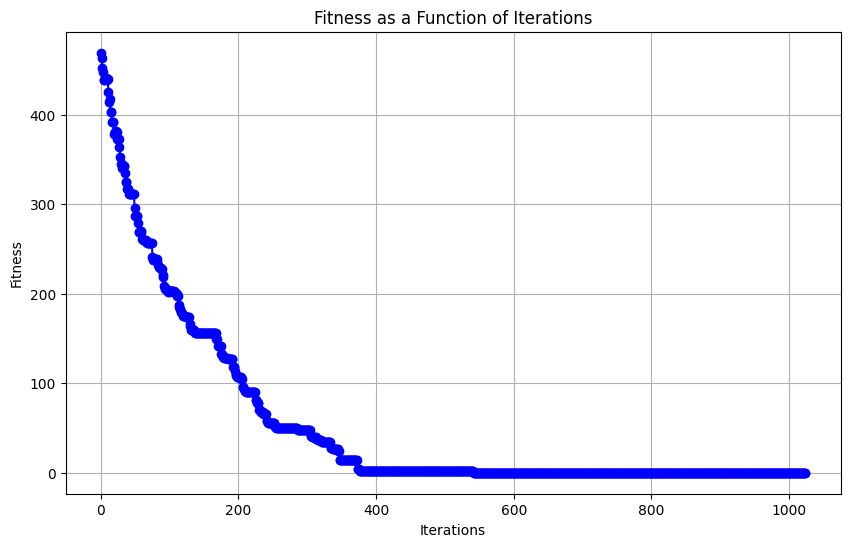

In [28]:
agg_fitness = wh_sa_run_curves.groupby('Iteration')['Fitness'].mean().reset_index()

# Extract iteration and fitness data
iterations = agg_fitness['Iteration']
fitness_values = agg_fitness['Fitness']

# Plot the fitness as a function of iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, fitness_values, marker='o', linestyle='-', color='b')
plt.title('Fitness as a Function of Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.grid(True)
plt.show()

In [26]:
rhc = RHCRunner(problem=problem,
              experiment_name='warehouse_rhc',
              output_directory="./warehouse", # note: specify an output directory to have results saved to disk
              seed=42,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              restart_list=[0, 5, 10, 25, 50, 100])

df_run_stats, df_run_curves = rhc.run()

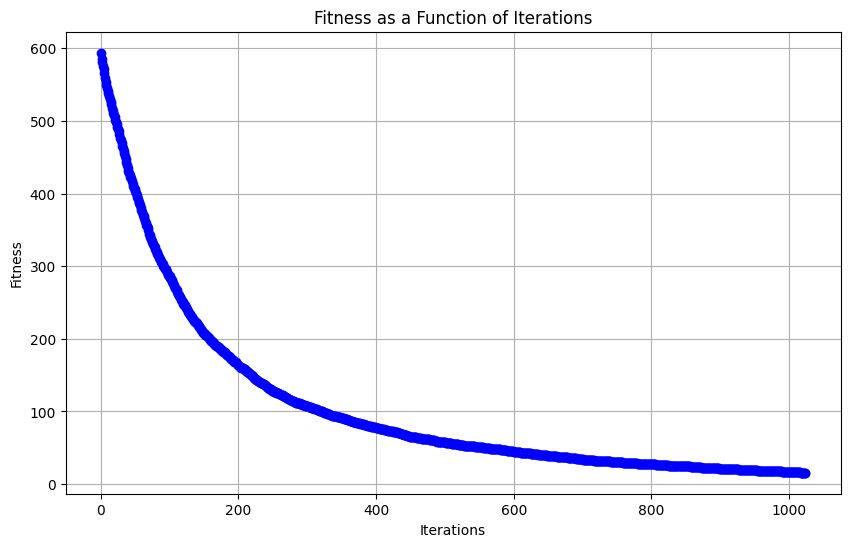

In [28]:
rhc_agg_fitness = df_run_curves.groupby('Iteration')['Fitness'].mean().reset_index()

# Extract iteration and fitness data
iterations = rhc_agg_fitness['Iteration']
fitness_values = rhc_agg_fitness['Fitness']

# Plot the fitness as a function of iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, fitness_values, marker='o', linestyle='-', color='b')
plt.title('Fitness as a Function of Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.grid(True)
plt.show()

In [29]:
ga = GARunner(problem=problem,
              experiment_name='warehouse_rhc',
              output_directory="./warehouse", # note: specify an output directory to have results saved to disk
              seed=42,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              population_sizes=[100, 200, 300],
              mutation_rates=[0.1, 0.15, 0.2])

wh_ga_run_stats, wh_ga_run_curves = ga.run()

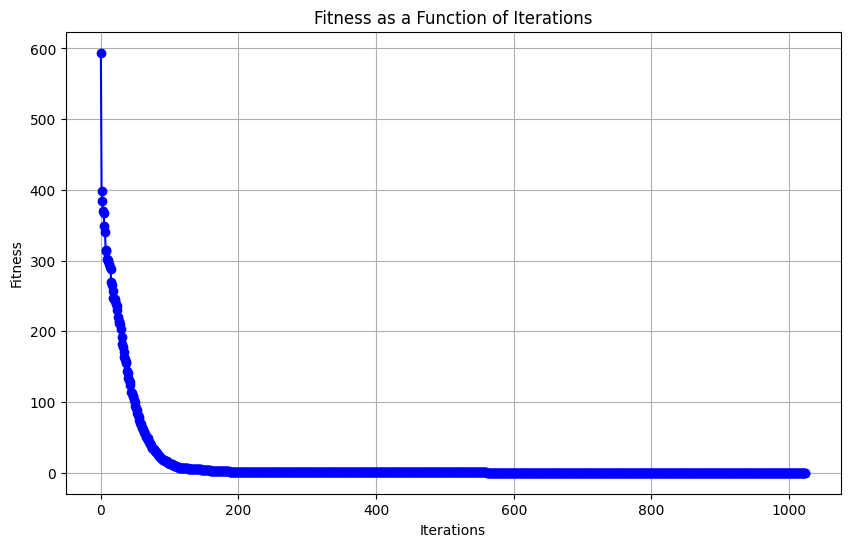

In [30]:
ga_agg_fitness = wh_ga_run_curves.groupby('Iteration')['Fitness'].mean().reset_index()

# Extract iteration and fitness data
iterations = ga_agg_fitness['Iteration']
fitness_values = ga_agg_fitness['Fitness']

# Plot the fitness as a function of iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, fitness_values, marker='o', linestyle='-', color='b')
plt.title('Fitness as a Function of Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.grid(True)
plt.show()

In [31]:
print("Total fitness evaluations:", wh_ga_run_stats['FEvals'].iloc[-1])

Total fitness evaluations: 184560


In [32]:
wh_ga_run_stats

,Iteration,Fitness,FEvals,Time,State,Population Size,Mutation Rate,max_iters
0,0,594.0,100,0.016549,"[6, 3, 7, 4, 6, 9, 2, 6, 7, 4, 3, 7, 7, 2, 5, ...",100,0.1,1024
1,1,396.0,202,0.052679,"[6, 3, 1, 8, 9, 8, 6, 2, 0, 3, 2, 0, 3, 3, 7, ...",100,0.1,1024
2,2,396.0,303,0.069634,"[6, 3, 1, 8, 9, 8, 6, 2, 0, 3, 2, 0, 3, 3, 7, ...",100,0.1,1024
3,4,364.0,506,0.101274,"[8, 4, 6, 6, 4, 4, 3, 3, 8, 8, 5, 8, 4, 2, 9, ...",100,0.1,1024
4,8,282.0,912,0.156402,"[3, 3, 1, 3, 6, 1, 2, 2, 8, 7, 5, 5, 6, 7, 7, ...",100,0.1,1024
...,...,...,...,...,...,...,...,...
103,64,100.0,19591,2.907033,"[5, 5, 4, 4, 4, 4, 4, 4, 3, 2, 3, 5, 3, 4, 4, ...",300,0.2,1024
104,128,0.0,38876,5.546097,"[5, 5, 4, 4, 1, 1, 4, 4, 3, 3, 5, 5, 4, 4, 4, ...",300,0.2,1024
105,256,0.0,77404,10.937572,"[5, 5, 4, 4, 1, 1, 4, 4, 3, 3, 5, 5, 4, 4, 4, ...",300,0.2,1024
106,512,0.0,154460,21.633761,"[5, 5, 4, 4, 1, 1, 4, 4, 3, 3, 5, 5, 4, 4, 4, ...",300,0.2,1024


In [37]:
best_state = wh_ga_run_stats.loc[wh_ga_run_stats['Fitness'].idxmin()]['State']
best_fitness = wh_ga_run_stats['Fitness'].min()


In [42]:
best_state_str = best_state

In [46]:
print(orders)

[array([43, 40, 46, 12, 24, 31, 17]), array([30, 36,  2, 48, 42]), array([ 1, 49,  5]), array([25, 46, 13, 48]), array([39,  7, 29, 30,  9,  6, 17, 24]), array([36, 45, 12, 16, 33, 42, 19,  9, 23]), array([ 8, 24]), array([ 4, 42, 27]), array([35, 30, 39,  2, 43, 10]), array([14, 46,  6]), array([21]), array([42,  7,  0,  5,  1, 39, 22]), array([25]), array([33]), array([49,  3,  7, 40]), array([23, 22, 47, 19, 42]), array([13,  0, 30]), array([15, 38, 27,  3, 46, 32]), array([28, 22, 27, 30, 14, 23, 29, 37, 34]), array([32, 15])]


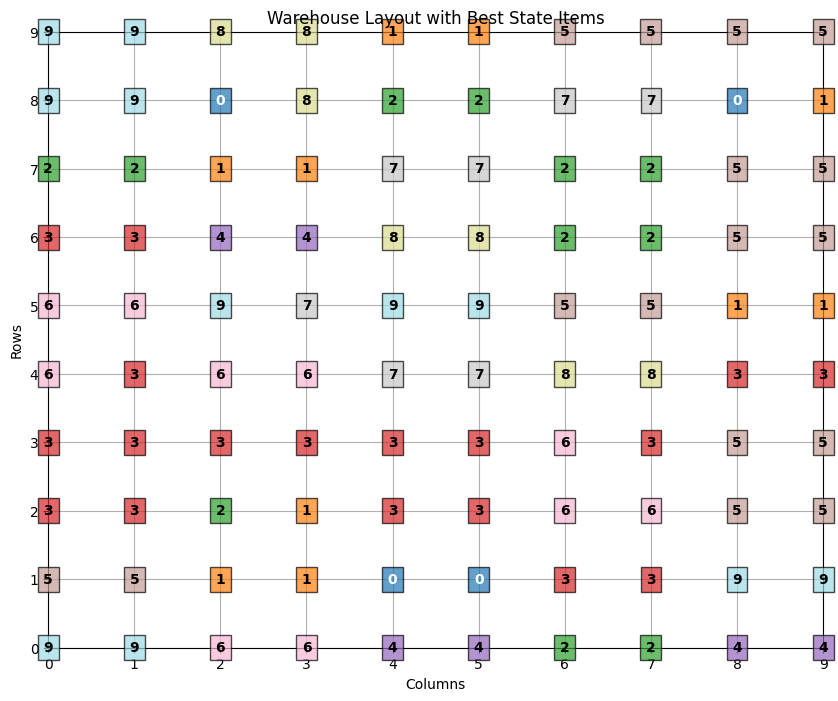

In [44]:
num_rows = 10
num_cols = 10
warehouse_layout = np.zeros((num_rows, num_cols))
best_state = eval(best_state_str)

# Map items from the best state to positions in the warehouse layout
for idx, item in enumerate(best_state):
    row = idx // num_cols
    col = idx % num_cols
    warehouse_layout[row, col] = item

# Plotting the warehouse layout
plt.figure(figsize=(10, 8))

# Create a colormap for visualization (adjust colors as needed)
cmap = plt.get_cmap('tab20', np.max(best_state) + 1)

# Plot each cell in the warehouse grid
for i in range(num_rows):
    for j in range(num_cols):
        item = int(warehouse_layout[i, j])
        plt.text(j, i, str(item), ha='center', va='center', color='white' if item == 0 else 'black', fontsize=10, fontweight='bold', bbox=dict(facecolor=cmap(item), alpha=0.7))

plt.title('Warehouse Layout with Best State Items')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.xticks(range(num_cols))
plt.yticks(range(num_rows))
plt.grid(True)
plt.show()

In [47]:
np.random.choice(range(num_items), size=np.random.randint(1, 10), replace=False)

array([15, 22,  2, 38,  9,  7, 17, 12])

In [16]:
initial_layout

{0: (0, 7),
 1: (9, 1),
 2: (2, 1),
 3: (2, 6),
 4: (0, 9),
 5: (7, 9),
 6: (9, 9),
 7: (1, 2),
 8: (8, 6),
 9: (3, 9),
 10: (4, 1),
 11: (7, 3),
 12: (8, 4),
 13: (8, 3),
 14: (9, 4),
 15: (8, 7),
 16: (2, 0),
 17: (2, 3),
 18: (1, 0),
 19: (6, 7),
 20: (6, 4),
 21: (0, 6),
 22: (6, 8),
 23: (2, 8),
 24: (0, 0)}

In [29]:
# Define job-shop data
jobs_data = [
    [(0, 3), (1, 2), (2, 2)],  # Job 0
    [(0, 2), (2, 1), (1, 4)],  # Job 1
    [(1, 4), (2, 3)]           # Job 2
]

num_jobs = len(jobs_data)
num_machines = max(max(task[0] for task in job) for job in jobs_data) + 1

# Flatten the job data to a list of tasks
tasks = [(job_id, machine_id, duration) for job_id, job in enumerate(jobs_data) for machine_id, duration in job]
num_tasks = len(tasks)

In [140]:
tasks

[(0, 0, 3),
 (0, 1, 2),
 (0, 2, 2),
 (1, 0, 2),
 (1, 2, 1),
 (1, 1, 4),
 (2, 1, 4),
 (2, 2, 3)]

In [144]:
def job_shop_fitness(state):
    # state is a permutation of task indices
    schedule = [tasks[i] for i in state]
    #print(f'Schedule is {schedule}')
    
    # Initialize machine completion times and job completion times
    machine_times = [0] * num_machines
    job_times = [0] * num_jobs
    
    # Initialize the last completed task index for each job
    last_task_index = {job_id: -1 for job_id in range(num_jobs)}

    #print(last_task_index)
    
    # Initialize the makespan and penalty
    makespan = 0
    penalty = 0
    duplicate_penalty = 0
    penalty_value = 50  # Penalty for executing a task out of order
    
    for job_id, machine_id, duration in schedule:
        # Check if the current task is the next in sequence for its job
        if last_task_index[job_id] + 1 != state[tasks.index((job_id, machine_id, duration))]:
            penalty += penalty_value
            #print('Penalty assessed')
        else:
            # Update the last completed task index for the job
            last_task_index[job_id] += 1
            
            # Calculate the start time for the current task
            start_time = max(machine_times[machine_id], job_times[job_id])
            # Calculate the end time for the current task
            end_time = start_time + duration
            
            # Update machine and job completion times
            machine_times[machine_id] = end_time
            job_times[job_id] = end_time
        #print(f'Last task index after task completion:  {last_task_index}')
    
    # The fitness is the makespan (total completion time) plus any penalties
    makespan = max(machine_times)
    
    if len(schedule) != len(set(schedule)):
        duplicate_penalty = 500
        
    return makespan + penalty + duplicate_penalty

In [84]:
initial_state = np.random.permutation(num_tasks)

In [85]:
initial_state

array([0, 4, 2, 6, 7, 1, 5, 3])

In [86]:
makespan = job_shop_fitness(initial_state)

Schedule is [(0, 0, 3), (1, 2, 1), (0, 2, 2), (2, 1, 4), (2, 2, 3), (0, 1, 2), (1, 1, 4), (1, 0, 2)]
{0: -1, 1: -1, 2: -1}
Last task index after task completion:  {0: 0, 1: -1, 2: -1}
Penalty assessed
Last task index after task completion:  {0: 0, 1: -1, 2: -1}
Penalty assessed
Last task index after task completion:  {0: 0, 1: -1, 2: -1}
Penalty assessed
Last task index after task completion:  {0: 0, 1: -1, 2: -1}
Penalty assessed
Last task index after task completion:  {0: 0, 1: -1, 2: -1}
Penalty assessed
Last task index after task completion:  {0: 0, 1: -1, 2: -1}
Penalty assessed
Last task index after task completion:  {0: 0, 1: -1, 2: -1}
Penalty assessed
Last task index after task completion:  {0: 0, 1: -1, 2: -1}


In [87]:
makespan

7003

In [ ]:
fitness = mlr.CustomFitness(job_shop_fitness)

# Define the optimization problem object
problem = mlr.DiscreteOpt(length=num_tasks, fitness_fn=fitness, maximize=False, max_val=num_tasks)

# Define the initial state (a random permutation of task indices)
initial_state = np.random.permutation(num_tasks)

# Set up the simulated annealing runner
sa = mlr.SARunner(problem=problem,
                            experiment_name="job_shop_scheduling_sa",
                            output_directory="./job_shop_scheduling",
                            seed=42,
                            iteration_list=2 ** np.arange(25),  # Number of iterations
                            max_attempts=100000,
                            temperature_list=[0.1, 0.5, 0.75, 1.0, 2.0, 5.0, 7.0, 10.0, 100.0, 1000.0],  # Initial temperature
                            decay_list=[mlr.GeomDecay],
                            init_state=initial_state)  # Set initial state

# Run the simulated annealing algorithm
jss_sa_run_stats, jss_sa_run_curves = sa.run()

In [ ]:
jss_sa_run_stats


In [184]:
best_state = jss_sa_run_stats.loc[jss_sa_run_stats['Fitness'].idxmin()]['State']
best_state

'[5, 3, 2, 6, 1, 0, 4, 7]'

In [149]:
def plot_best_state_jss(best_state):
    # Extract the best schedule from the best state
    best_schedule = [tasks[i] for i in best_state]
    print(best_schedule)
    
    # Reconstruct the schedule including start and end times for each task
    machine_times = [0] * num_machines
    job_times = [0] * num_jobs
    gantt_data = []
    
    for job_id, machine_id, duration in best_schedule:
        start_time = max(machine_times[machine_id], job_times[job_id])
        end_time = start_time + duration
        machine_times[machine_id] = end_time
        job_times[job_id] = end_time
        gantt_data.append((job_id, machine_id, start_time, end_time))

    print(gantt_data)
    
    # Plot the Gantt chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plotting bars for tasks
    for idx, (job_id, machine_id, start_time, end_time) in enumerate(gantt_data):
        if job_id == 0:
            color = 'y'
        elif job_id == 1:
            color = 'b'
        else:
            color = 'r'
        ax.barh(machine_id, end_time - start_time, left=start_time, height=0.7, align='center', color=color, alpha=0.7, edgecolor='black')
    
    # Adding labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Machine')
    ax.set_title('Job Shop Scheduling Gantt Chart')
    
    # Setting y-axis ticks and labels
    ax.set_yticks(range(num_machines))
    ax.set_yticklabels([f'Machine {i}' for i in range(num_machines)])
    
    # Inverting y-axis to have Machine 0 at the top
    ax.invert_yaxis()
    
    # Adding grid lines for better readability
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

[(1, 0, 2), (0, 2, 2), (2, 2, 3), (1, 2, 1), (1, 1, 4), (2, 1, 4), (0, 1, 2), (0, 0, 3)]
[(1, 0, 0, 2), (0, 2, 0, 2), (2, 2, 2, 5), (1, 2, 5, 6), (1, 1, 6, 10), (2, 1, 10, 14), (0, 1, 14, 16), (0, 0, 16, 19)]


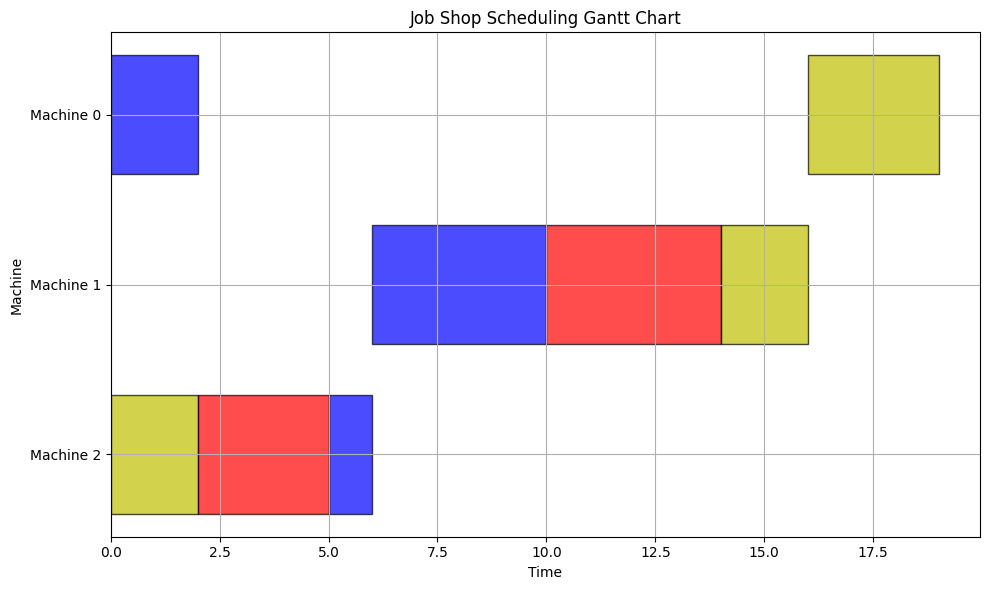

In [183]:
plot_best_state_jss(eval(best_state))

In [158]:
def random_neighbor(state):
        """Return random neighbor of current state vector.

        Returns
        -------
        neighbor: array
            State vector of random neighbor.
        """
        neighbor = np.copy(state)
        i = np.random.randint(0,8)

        vals = list(np.arange(8))
        vals.remove(neighbor[i])
        neighbor[i] = vals[np.random.randint(0, 7)]

        return neighbor

In [159]:
random_neighbor(best_state)

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [167]:
neighbor = np.copy(best_state)
i = np.random.randint(0, 8)
vals = list(np.arange(8))

In [176]:
vals[np.random.randint(0, 7)]

5

In [177]:
list(neighbor[i])

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [171]:
vals[neighbor[i]]

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed